# Job title prediction with embedding

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')                                                                                          

In [2]:
import pandas as pd
import numpy as np
import cufflinks as cf; cf.go_offline()

In [3]:
pd.set_option('max_colwidth',250)

## Loading the data

#### The link to the dataset with Parts of speach:
* https://drive.google.com/file/d/1UH5yhX614pcL4yCtngrvTF8PqxGoTrex/view?usp=sharing

In [4]:
from ast import literal_eval
df_pos = pd.read_csv("datasets/data_with_POS.csv",converters={"Desc": literal_eval,
                                                                "Desc_POS": literal_eval,
                                                                "Desc_noun_only": literal_eval})
df_pos.head(2)

,ExtJobTitleText,JobTitle,Description,Desc,DescLength,DescriptionLength,Desc_POS,count_of_nouns,percentage_of_nouns_in_Desc,Desc_noun_only,is_extractive
0,Business Development Center Agent,Medical Scientist,"For generations, the Landers family has been in the car business.<br/>Steve Landers Chrysler Dodge Jeep continues to build its brand on family values and a philosophy of serving its guests, team members, and communities.<br/>Every Landers team me...","[flexible, required, date, owned, strong, excel, bring, screening, dodge, employee, productivityyou, skills, trained, tasks, assisting, must, microsoft, professional, responsibilities, carefully, business, inquires, requests, include, resources, ...",205,2765,"[(flexible, JJ), (required, VBN), (date, NN), (owned, VBN), (strong, JJ), (excel, RB), (bring, VBG), (screening, VBG), (dodge, NN), (employee, NN), (productivityyou, NN), (skills, NNS), (trained, VBD), (tasks, NNS), (assisting, VBG), (must, MD), ...",114,0.56,"[date, dodge, employee, productivityyou, skills, tasks, responsibilities, business, inquires, requests, resources, job, training, offers, position, excellent, preemployment, requirements, weekends, agent, health, tasksyou, communitiesevery, philo...",False
1,Technician I,Automotive Technician,"<div class=""earcu_posdescriptionContainer""><div class=""earcu_posdescription""><div class=""earcu_posdescriptionnote""><p>Avis Budget Group is an action-packed, high-energy workplace. We are a global leader in the travel services industry operating t...","[may, required, avis, date, stay, needed, rental, much, screening, constitute, completed, skills, shop, license, must, management, professional, responsibilities, publicly, properly, travel, diagnostics, business, forward, response, safety, time,...",236,4502,"[(may, MD), (required, VB), (avis, NN), (date, NN), (stay, NN), (needed, VBD), (rental, JJ), (much, JJ), (screening, NN), (constitute, NN), (completed, VBD), (skills, NNS), (shop, NN), (license, NN), (must, MD), (management, NN), (professional, J...",120,0.51,"[avis, date, stay, screening, constitute, skills, shop, license, management, responsibilities, diagnostics, business, response, safety, time, drug, change, job, ad, brands, offers, environment, bulletins, position, requirements, year, variety, ac...",True


In [5]:
print(type(df_pos.Desc_POS.iloc[0]))
df_pos.Desc_POS.iloc[0][:10]

<class 'list'>


[('flexible', 'JJ'),
 ('required', 'VBN'),
 ('date', 'NN'),
 ('owned', 'VBN'),
 ('strong', 'JJ'),
 ('excel', 'RB'),
 ('bring', 'VBG'),
 ('screening', 'VBG'),
 ('dodge', 'NN'),
 ('employee', 'NN')]

In [6]:
df_pos.shape

(30673, 11)

In [7]:
df_pos["Desc_concatinated"] = df_pos.Desc.apply(lambda x: ' '.join(x))
df_pos.Desc_concatinated[0]

'flexible required date owned strong excel bring screening dodge employee productivityyou skills trained tasks assisting must microsoft professional responsibilities carefully business inquires requests include resources upon maintaining job ready training offers positive position excellent preemployment requirements accident able weekends successfully offer hit minimal agent health tasksyou serve communitiesevery philosophy ethicthe dental businesssteve outcome term commission customers in’s check computer relationships appointments background ongoing high followup plus customer submit members serious hourly technology goals energy databaseswhat expert ground wellgroomed care call verification value fulfilling chrysler vehicle out’s optional providing available critical need car number jeep pet applicants assists resolving serving appearance spending build day outlook driving team criminal continues questions problems entering ‘a weekly growth duties new asking know existing daily pro

In [8]:
df_pos["JobTitle_tokenized"] = pd.factorize(df_pos.JobTitle)[0]

In [57]:
df_pos.drop_duplicates(subset=['job_description'], inplace=True)
df_pos.dropna(inplace=True)

In [58]:
df_pos.shape

(111438, 3)

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(min_df=5).fit(df_pos['job_description'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

66249


In [60]:
df_pos["JobTitle_tokenized"] = pd.factorize(df_pos.job_title)[0]

In [61]:
df_pos["ext_job_title_tokenized"] = pd.factorize(df_pos.ext_job_title)[0]

In [63]:
df_pos.job_title.value_counts().to_frame(name='amount')

,amount
Information Systems Security Officer,46
Supply Chain Manager,46
Cell Biologist,46
Legal Officer,46
Caterer,46
...,...
Leasing Consultant,1
Adjustment Representative,1
Legislative Aide,1
Telecommunications Sales Manager,1


### Reshape th df, min rows

In [64]:
def reshape_df(df, the_min_amount_of_rows = 10, the_max_amount_of_rows = 100):
    list_of_two_parts = [pd.DataFrame(columns=df.columns)] * 2    ## In the end we want to concat the two part
    
    df_jobs_count = df.job_title.value_counts().to_frame(name='amount')
    
    ## Droping every row under minimum amount of observations
    df_jobs_to_drop = df_jobs_count.query(f'amount<{the_min_amount_of_rows}')
    list_jobs_to_drop = list(df_jobs_to_drop.index)
    df = df[-df.job_title.isin(list_jobs_to_drop)]
    
    ## Creating the first part of list, the one we don't touch
    df_jobs_no_problem = df_jobs_count.query(f'amount>={the_min_amount_of_rows} & amount<={the_max_amount_of_rows}')
    list_of_two_parts[0] = df[df.job_title.isin(df_jobs_no_problem.index)]
    
    ## Creating the the second part of the list, where we resample the jobs with too many rows
    df_jobs_to_resample = df_jobs_count.query(f'amount>{the_max_amount_of_rows}')
    list_jobs_to_resample = list(df_jobs_to_resample.index)
    df_for_resampling = df[df.job_title.isin(list_jobs_to_resample)]
    
    list_of_subsets = [pd.DataFrame(columns=df.columns)] * len(list_jobs_to_resample)
    for i in range(len(list_jobs_to_resample)):
        list_of_subsets[i] = df_for_resampling[df_for_resampling.job_title == list_jobs_to_resample[i]].sample(the_max_amount_of_rows)
    if len(list_of_subsets) !=0:
           list_of_two_parts[1] = pd.concat(list_of_subsets)
    
    return pd.concat(list_of_two_parts)

In [65]:
df = reshape_df(df_pos, the_min_amount_of_rows = 5, the_max_amount_of_rows = 100)

In [66]:
df.job_title.value_counts().to_frame(name='amount')

,amount
Conference Specialist,46
Cardiac Surgeon,46
Material Handler,46
Dispensary Patient Consultant,46
Optician,46
...,...
Cardiac Exercise Specialist,5
Career Education Coordinator,5
Cargo Technician,5
Cash Management Analyst,5


### Train and test set split

In [9]:
text_col, target_col = 'Desc_concatinated', 'JobTitle_tokenized'

from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()

label_as_binary.fit(df_pos[target_col])

training_set = df_pos[[text_col, target_col]].sample(frac=0.8, random_state=41)
test_set = df_pos[~df_pos.index.isin(training_set.index)][[text_col, target_col]]

train__y_labels = label_as_binary.transform(training_set[target_col])
test__y_labels = label_as_binary.transform(test_set[target_col])

In [10]:
assert(len(training_set) + len(test_set) == len(df_pos))

* creating train_y_labels variable because it works for the model

In [11]:
# from sklearn.preprocessing import LabelBinarizer
# label_as_binary = LabelBinarizer()
# train_y_labels = label_as_binary.fit_transform(training_set[target_col])
# type(train_y_labels)

## Embedding with pooling and all words

In [12]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [13]:
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout, Reshape, Activation

What is a good size for the vocabulary? 

In [14]:
df_pos.Desc_concatinated.apply(lambda x: len(x.split(' '))).quantile([0.5,0.6,0.7,0.8,0.9,0.95,0.99])

0.50    119.00
0.60    150.00
0.70    169.00
0.80    195.00
0.90    248.00
0.95    282.00
0.99    402.28
Name: Desc_concatinated, dtype: float64

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(min_df=5).fit(df_pos['Desc_concatinated'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

19794


In [16]:
vocab_size = 20000
sequence_length = 282

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    max_tokens=vocab_size,
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length
)

In [17]:
vectorize_layer.adapt(training_set[text_col])

In [18]:
sample_description = training_set[text_col].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

caree started immediatelyshift njstarting washington full provider cleanerlocation integrated many leading solutions looking avenue square abm timeabm centersome constantly move feet cleaner like large leaders hiring million distribution warehouse facility centers perfect carlstadt role


<tf.Tensor: shape=(282,), dtype=int64, numpy=
array([11977,  1447,  4874, 13087,  2935,    99,   163,  4924,  2200,
         136,   223,   260,    14,  3135,  3151,  4932,  4892,  4925,
        2077,   270,  1290,  3314,    37,   710,   555,    40,  1763,
         932,   168,   373,  1055,  1531,     1,    74,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [19]:
# for token in vectorize_layer(sample_description).numpy()[:20]:
#     print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

### Modeling

### Descriptions squashed into 1 average embedding vector, size 16

In [20]:
embedding_dim=32

model = tf.keras.Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
#     Dropout(0.03),
    Dense(4096, activation='elu', name='hidden_layer'),
#     Dropout(0.01),
#     Dense(2048, activation='elu', name='hidden_layer2'),
#     Dropout(0.02),
#     Dense(1024, activation='relu', name='hidden_layer2'),
    Dense(df_pos.JobTitle.nunique(), name = 'output_layer', activation='softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 282)              0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 282, 32)           640000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 4096)              135168    
                                                                 
 output_layer (Dense)        (None, 1953)              8001441   
                                                                 
Total params: 8,776,609
Trainable params: 8,776,609
Non-

In [22]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy']
    )

#### Creating checkpoints for model weights

In [24]:
# checkpoint_path = 'Deep_models_weights'
cp_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath='model.{epoch:02d}-{val_loss:.4f}.tf', 
    verbose=1, 
    save_weights_only=True,
    save_freq= 'epoch')]

In [25]:
from tensorflow import keras

checkpoint_path = 'Deep_models_weights'
callbacks  = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch'),
    keras.callbacks.EarlyStopping(
        monitor='val_recall',
        min_delta=0,
        patience=20,
        verbose=1)
    ]

#### Model fit

In [28]:
%%time
history = model.fit(
    training_set[text_col],
    train__y_labels,
    epochs=15,
    batch_size=1024,
    verbose=1,
    callbacks=cp_callback,
    validation_data = (test_set[text_col], test__y_labels)
)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 3.5464 - precision: 0.9396 - recall: 0.1515 - accuracy: 0.3171
Epoch 00001: saving model to model.01-3.7682.tf
24/24 [==============================] - 25s 1s/step - loss: 3.5464 - precision: 0.9396 - recall: 0.1515 - accuracy: 0.3171 - val_loss: 3.7682 - val_precision: 0.9315 - val_recall: 0.1464 - val_accuracy: 0.3379
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 3.4362 - precision: 0.9363 - recall: 0.1624 - accuracy: 0.3387
Epoch 00002: saving model to model.02-3.6780.tf
24/24 [==============================] - 27s 1s/step - loss: 3.4362 - precision: 0.9363 - recall: 0.1624 - accuracy: 0.3387 - val_loss: 3.6780 - val_precision: 0.9361 - val_recall: 0.1767 - val_accuracy: 0.3470
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 3.3216 - precision: 0.9210 - recall: 0.1830 - accuracy: 0.3551
Epoch 00003: saving model to model.03-3.5880.tf
24/24 [==============================] - 

KeyboardInterrupt: 

In [ ]:
model2 = 

### Simple NN Prediction & Evaluation

In [41]:
import matplotlib.pyplot as plt

<AxesSubplot:>

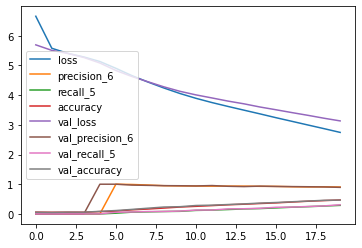

In [94]:
pd.DataFrame(history.history).plot()

In [130]:
test_set['token_with_best_prediction'] = model.predict(test_set[text_col]).argmax(axis=1)

In [131]:
test_set['prob_token_with_best_prediction'] = model.predict(test_set[text_col]).max(axis=1)

In [133]:
test_set.sample(5)

,Desc_concatinated,JobTitle_tokenized,token_with_best_prediction,prob_token_with_best_prediction
29572,cambria parttime therapist week studentsb september medford work school position language pathologist days,1073,1073,0.851287
25505,everyone house morning time training managers youve assistant maybe chance get bosses nows,829,140,0.083591
24811,maintains securing materials handlers documents positions hour zipx handler guns crating product supplies disposition orders inventory use ability rf assemblyproduction stock loading job shifts lines work position jacks requirements term location...,105,105,0.869836
21925,road happyits online customer hour adtpizzato prep service dishwashers fun call hut cashiers friends member offer hiring location charlotte cashas pay production albermarle people,140,204,0.764876
8254,supervise airline operation skills management responsibilities measures agreements aircraft business safety resources policy items areas quality job sops qualifications cargo activities years line employer variances availability improvement satis...,866,866,0.091597


In [49]:
history.history

{'loss': [7.0797905921936035,
  5.626489162445068,
  5.455383777618408,
  5.366490840911865,
  5.274999618530273,
  5.175516605377197,
  5.047900676727295,
  4.867799758911133,
  4.685567378997803,
  4.526503086090088],
 'accuracy': [0.054283153265714645,
  0.05615779757499695,
  0.05615779757499695,
  0.05615779757499695,
  0.05660608038306236,
  0.057339634746313095,
  0.0831771120429039,
  0.09968212246894836,
  0.13285516202449799,
  0.15249817073345184],
 'val_loss': [5.97400426864624,
  5.530951976776123,
  5.462557315826416,
  5.377357006072998,
  5.277641773223877,
  5.172201633453369,
  5.015959739685059,
  4.832588195800781,
  4.6812005043029785,
  4.554471492767334],
 'val_accuracy': [0.0570497140288353,
  0.0570497140288353,
  0.0570497140288353,
  0.0570497140288353,
  0.0570497140288353,
  0.05884270742535591,
  0.08622656762599945,
  0.13072533905506134,
  0.15175224840641022,
  0.1595762073993683]}

### Making a loop to see the best metrics

In [310]:
pool_embedding_results = [0]*100
for i in range(100):
    history_loop = model.fit(
                    training_set[text_col],
                    train__y_labels,
                    epochs=1,
                    batch_size=1024,
                    verbose=1,
                    validation_data = (test_set[text_col], test__y_labels))
    
    pred = model.predict(test_set[text_col])
    test_set['token_with_best_prediction'] = pred.argmax(axis=1)
#     test_set['prob_token_with_best_prediction'] = pred.max(axis=1)
    
    pool_embedding_results[i] = [i,
                                precision_score(test_set['JobTitle_tokenized'],test_set['token_with_best_prediction'], average="weighted",zero_division=0),
                                recall_score(test_set['JobTitle_tokenized'],test_set['token_with_best_prediction'], average="weighted",zero_division=0), 
                                accuracy_score(test_set['JobTitle_tokenized'],test_set['token_with_best_prediction'])]

24/24 [==============================] - 61s 2s/step - loss: 0.3040 - accuracy: 0.9317 - val_loss: 3.7736 - val_accuracy: 0.6958


In [311]:
pool_embedding_results

[[0, 0.003254669953219101, 0.05704971475142624, 0.05704971475142624],
 [1, 0.003254669953219101, 0.05704971475142624, 0.05704971475142624],
 [2, 0.0033162930016607185, 0.05704971475142624, 0.05704971475142624],
 [3, 0.017272086940569864, 0.08427057864710677, 0.08427057864710677],
 [4, 0.022916740530969336, 0.09877750611246944, 0.09877750611246944],
 [5, 0.039550425286782175, 0.12550937245313773, 0.12550937245313773],
 [6, 0.06503488608164602, 0.15680521597392014, 0.15680521597392014],
 [7, 0.09059997097770556, 0.18321108394458027, 0.18321108394458027],
 [8, 0.11977846515671917, 0.20505297473512632, 0.20505297473512632],
 [9, 0.16936852078827577, 0.25509372453137735, 0.25509372453137735],
 [10, 0.1789007916168287, 0.2665036674816626, 0.2665036674816626],
 [11, 0.23638804274241088, 0.30138549307253465, 0.30138549307253465],
 [12, 0.26475922236900884, 0.33838630806845965, 0.33838630806845965],
 [13, 0.26905353638396645, 0.3439282803585982, 0.3439282803585982],
 [14, 0.319753274799048, 0.3

[0.693, 0.696]

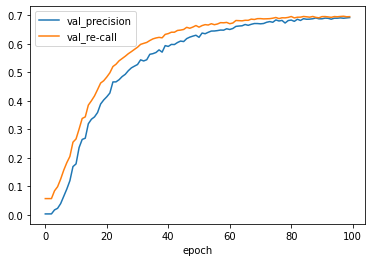

In [326]:
pd.DataFrame(pool_embedding_results, columns=['epoch','val_precision','val_re-call','val_accuracy']).set_index('epoch')[['val_precision','val_re-call']].plot()
[0.693, 0.696]

## Embedding with pooling nouns only

In [327]:
df_pos1 = df_pos.copy()

In [328]:
df_pos1["Desc_concatinated"] = df_pos1.Desc_noun_only.apply(lambda x: ' '.join(x))
df_pos1.Desc_concatinated[0]

'date dodge employee productivityyou skills tasks responsibilities business inquires requests resources job training offers position excellent preemployment requirements weekends agent health tasksyou communitiesevery philosophy ethicthe outcome term commission customers ’ s check computer appointments followup customer submit members technology goals energy ground care call verification value chrysler vehicle ’ providing need car number jeep pet applicants appearance spending day outlook team criminal questions problems growth duties opportunities guests security game ’ product supervisorqualifications phone hours records values offerings internet knowledge work word generations experience attitude transfers development discounts multitask match packages attention landers employment brand urgency passing insurance sales motor create information vision database reports communication family member vacation successour review entry detail illness'

In [329]:
df_pos1["JobTitle_tokenized"] = pd.factorize(df_pos1.JobTitle)[0]

* latest working version

In [332]:
text_col1, target_col1 = 'Desc_concatinated', 'JobTitle_tokenized'

from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()

label_as_binary.fit(df_pos1[target_col1])

training_set1 = df_pos1[[text_col1, target_col1]].sample(frac=0.8, random_state=41)
test_set1 = df_pos1[~df_pos1.index.isin(training_set1.index)][[text_col1, target_col1]]

train__y_labels1 = label_as_binary.transform(training_set1[target_col1])
test__y_labels1 = label_as_binary.transform(test_set1[target_col1])

In [333]:
assert(len(training_set1) + len(test_set1) == len(df_pos1))

In [286]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [287]:
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout, Reshape, Activation

What is a good size for the vocabulary? 

In [335]:
df_pos1.Desc_concatinated.apply(lambda x: len(x.split(' '))).quantile([0.5,0.6,0.7,0.8,0.9,0.95,0.99])

0.50     61.0
0.60     76.0
0.70     87.0
0.80    106.0
0.90    129.0
0.95    152.0
0.99    215.0
Name: Desc_concatinated, dtype: float64

In [336]:
vocab_size1 = 10000
sequence_length1 = 152

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer1 = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    max_tokens=vocab_size1,
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length1
)

In [337]:
vectorize_layer1.adapt(training_set1[text_col1])

In [343]:
sample_description1 = training_set1[text_col1].sample().iloc[0]
print(sample_description1)
vectorize_layer1(sample_description1)

practice iep dismissal psychology life students look determine responsibilities iepmaintain needsconduct goal time use change challenges priority reach position ethics qualifications superintendent offer educators hold k share san id state instruction code hire servicesparticipate notes associates ’ s goals evaluations country value gradewe company need responsibility dedication consult regards model students antonio passionate team assessment area boardassumes practices children district certificate hours certification schools school services office development orncsp passion residence lsspjoin summaries staff provider well recommendations performance levels treatment education ’ s difference txpart vision screenings psychologists process december child ’ children families sessions mission benefits objectives


<tf.Tensor: shape=(152,), dtype=int64, numpy=
array([  86,  831,  926, 1399,   71,  114,  291,  406,   12, 1257, 2341,
        346,   14,  151,  228,  393,  257,  200,    7,  592,   18, 2055,
        183,  308,  606,  208,  343, 1561,   68,   44, 1173,  229,  160,
        970,  521,  250,    2,   13,  152,  452,  304,  233, 1994,   16,
        188,  196,  241,  345,  472,  402,  114, 8650,  425,    6,  470,
         80, 2042,  103,   91,  481,  870,   19,  162, 1122,   20,   40,
        126,   51, 5284,  105, 1172,    1,  595,   73,  124,  768,  414,
        145,  150,  195,   70,    2,   13,  110,    1,   41,  529, 1729,
         66, 1342,  434,    2,   91,  282,  567,  155,   15,  335,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Modeling

### Descriptions squashed into 1 average embedding vector, size 16

In [344]:
embedding_dim1=32

model1 = tf.keras.Sequential([
    vectorize_layer1,
    Embedding(vocab_size1, embedding_dim1, name="embedding"),
    GlobalAveragePooling1D(),
#     Dropout(0.03),
    Dense(4096, activation='elu', name='hidden_layer'),
#     Dropout(0.01),
#     Dense(2048, activation='elu', name='hidden_layer2'),
#     Dropout(0.02),
#     Dense(1024, activation='relu', name='hidden_layer2'),
    Dense(df_pos1.JobTitle.nunique(), name = 'output_layer', activation='softmax')
])

In [345]:
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 152)              0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 152, 32)           320000    
                                                                 
 global_average_pooling1d_7   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 4096)              135168    
                                                                 
 output_layer (Dense)        (None, 1953)              8001441   
                                                                 
Total params: 8,456,609
Trainable params: 8,456,609
N

In [346]:
tf.keras.utils.plot_model(model1, show_dtype=True, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [347]:
model1.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy'])

#### Creating checkpoints for model weights

In [125]:
checkpoint_path = 'Deep_models_weights'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq= 'epoch')

#### Model fit

### Making a loop to see the best metrics

In [348]:
pool_embedding_results_noun_only = [0]*100
for i in range(100):
    history_loop = model1.fit(
                    training_set1[text_col1],
                    train__y_labels1,
                    epochs=1,
                    batch_size=1024,
                    verbose=1,
                    validation_data = (test_set1[text_col1], test__y_labels1))
    
    pred = model1.predict(test_set1[text_col1])
    test_set1['token_with_best_prediction'] = pred.argmax(axis=1)
    test_set1['prob_token_with_best_prediction'] = pred.max(axis=1)
    
    pool_embedding_results_noun_only[i] = [i,
                                    precision_score(test_set1['JobTitle_tokenized'],test_set1['token_with_best_prediction'], average="weighted",zero_division=0),
                                    recall_score(test_set1['JobTitle_tokenized'],test_set1['token_with_best_prediction'], average="weighted",zero_division=0), 
                                    accuracy_score(test_set1['JobTitle_tokenized'],test_set1['token_with_best_prediction'])]

24/24 [==============================] - 45s 2s/step - loss: 0.4356 - accuracy: 0.8958 - val_loss: 3.9809 - val_accuracy: 0.6577


In [349]:
pool_embedding_results_noun_only

[[0, 0.003254669953219101, 0.05704971475142624, 0.05704971475142624],
 [1, 0.0032552005482554915, 0.05704971475142624, 0.05704971475142624],
 [2, 0.003470780490700363, 0.05704971475142624, 0.05704971475142624],
 [3, 0.005305123132762117, 0.05884270578647107, 0.05884270578647107],
 [4, 0.021298051125740108, 0.08590057049714751, 0.08590057049714751],
 [5, 0.024922367133403633, 0.09176854115729421, 0.09176854115729421],
 [6, 0.0723993178799576, 0.1556642216788916, 0.1556642216788916],
 [7, 0.09012115459062435, 0.17310513447432763, 0.17310513447432763],
 [8, 0.14107378782434615, 0.22705786471067646, 0.22705786471067646],
 [9, 0.17122544497001507, 0.24205378973105135, 0.24205378973105135],
 [10, 0.19013323637156773, 0.27449062754686226, 0.27449062754686226],
 [11, 0.23569629770317047, 0.29991850040749796, 0.29991850040749796],
 [12, 0.2469838233829037, 0.3214343928280359, 0.3214343928280359],
 [13, 0.25357739950235825, 0.32942135289323554, 0.32942135289323554],
 [14, 0.30051820280618996, 0.

[0.654, 0.657]

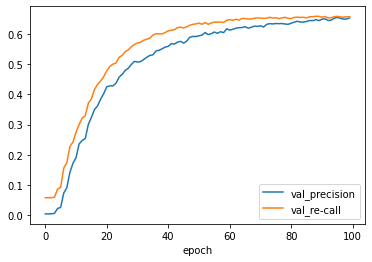

In [360]:
pd.DataFrame(pool_embedding_results_noun_only, columns=['epoch','val_precision','val_re-call','val_accuracy']).set_index('epoch')[['val_precision','val_re-call']].plot()
[0.654, 0.657]

### Descriptions words concatinated

In [365]:
embedding_dim=32

model2 = tf.keras.Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
#     GlobalAveragePooling1D(),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
#     Dropout(0.1),
    Dense(4096, activation='relu', name='hidden_layer_1'),
#     Dropout(0.04),
#     Dense(2048, activation='relu', name='hidden_layer_2'),
    Dense(df_pos.JobTitle.nunique(), name = 'output_layer')
])

In [366]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 282)              0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 282, 32)           640000    
                                                                 
 concat_words (Reshape)      (None, 9024)              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 4096)              36966400  
                                                                 
 output_layer (Dense)        (None, 1953)              8001441   
                                                                 
Total params: 45,607,841
Trainable params: 45,607,841
Non-trainable params: 0
_________________________________________

In [204]:
tf.keras.utils.plot_model(model2, show_dtype=True, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [367]:
model2.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy'])

In [ ]:
%%time
history = model2.fit(
    training_set[text_col],
    train__y_labels,
    epochs=10,
    batch_size=1024,
    verbose=1,    
    validation_data = (test_set[text_col], test__y_labels)
)

Epoch 1/10
24/24 [==============================] - 197s 8s/step - loss: 9.3705 - accuracy: 0.0020 - val_loss: 8.9563 - val_accuracy: 9.7800e-04
Epoch 2/10
24/24 [==============================] - 163s 7s/step - loss: 8.6769 - accuracy: 0.0038 - val_loss: 8.5029 - val_accuracy: 0.0021
Epoch 3/10
24/24 [==============================] - 166s 7s/step - loss: 11.8334 - accuracy: 0.0112 - val_loss: 12.8041 - val_accuracy: 0.0215
Epoch 4/10
24/24 [==============================] - 176s 7s/step - loss: 12.6228 - accuracy: 0.0211 - val_loss: 12.3476 - val_accuracy: 0.0215
Epoch 5/10
24/24 [==============================] - 166s 7s/step - loss: 11.7183 - accuracy: 0.0211 - val_loss: 12.6059 - val_accuracy: 0.0215
Epoch 6/10
24/24 [==============================] - 173s 7s/step - loss: 12.2820 - accuracy: 0.0211 - val_loss: 12.5785 - val_accuracy: 0.0215
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 12.1318 - accuracy: 0.0211

In [207]:
test_set['token_with_best_prediction'] = model.predict(test_set[text_col]).argmax(axis=1)

In [208]:
test_set['prob_token_with_best_prediction'] = model.predict(test_set[text_col]).max(axis=1)

In [209]:
test_set.head(20)

,Desc_concatinated,JobTitle_tokenized,token_with_best_prediction,prob_token_with_best_prediction
9,customers flexible owned operated relationships needed partners repairs back responsible candidate businessour systemmust customer profilesmust assisting donequalifications go beyond repair ideal willing estimator collision insurance coming drp j...,6,62,0.026180
11,may flexible required avis much rental screening constitute completed nights skills shop license management tech professional responsibilities publicly properly travel business forward response safety time drug include somewhere upon change track...,8,1,0.406902
13,consecutive best flexible strong ft dynamic referral app practice cme clinical one array please management professional local extensive board bed department since american designation several track albemarle quality recognized training settings s...,10,2,0.382722
16,required supervised practice cme crna’s pto walking must gives close pediatrics increased hearts lungs surgery south onboarding recovery offers environment endoscopy public year residents advanced experienced additional competitive clermont least...,12,45,0.802430
24,may output required avis strong excel rental along robotics skills reviews must software resolutions updates performed responsibilities closely benefitswe business analytical contain liaise log architect disclaimerthe function department time inc...,16,495,0.219630
25,may administration impacted flexible install directory required research backups needed strong xenapp skills windows license tasks scale software installation cpu microsoft management professional etc cissp netscaler business analytical planning ...,17,550,0.349386
40,may medicationsdelegates practice screening skills nurse practitioner kansasthe license employmentthis professional years’ mental prescribes pioneer universal safety drug include psychiatristprovides united schedulesubject position approved regul...,2,44,0.394109
53,required screening clinical skills online professional pioneer morning planning recordprovision time drug include patients upon united facilityparticipation either onboarding good industryour agencies provision lpeat able activities years success...,33,34,0.557142
55,teamevaluate disabilityprotected required strong wellbeing needed federal screening clinical skills truly governing without nurse license must eoe calling choosing responsibilities pioneer response improve mo demonstrate drug use patients quality...,29,29,0.841705
60,teamevaluate disabilityprotected required nj strong wellbeing needed federal screening clinical skills truly governing without nurse license must eoe juvenile calling choosing responsibilities pioneer response improve demonstrate time drug use pa...,29,29,0.931704


### Adding additional features (besides text)

#### Extracting Year column

In [64]:
from dateutil.parser import parse
def extract_year_from_title(title):
    try:
        year = parse(title, fuzzy=True).year
        return str(int(year)) if year > 1800 else None
    except:
        return None

In [65]:
sample_title = wine_reviews.sample().title.iloc[0]
print(f'Title is: {sample_title}. Extracted year: {extract_year_from_title(sample_title)}')

Title is: Penya 2016 Grenache Noir-Syrah Rosé (Côtes Catalanes). Extracted year: 2016


In [66]:
wine_reviews['year'] = wine_reviews.title.apply(extract_year_from_title)
wine_reviews['year'].value_counts(dropna=False).head(10)

C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning:

tzname WA identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



2013    15558
2012    15420
2014    15278
2011    12329
2010    11927
2015     9889
2009     9706
2008     7326
2007     6935
NaN      6659
Name: year, dtype: int64

Is the year input informative? 

In [23]:
wine_reviews.groupby('year').points.describe().query('count > 20').sort_values(by='mean',ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1995,47.0,89.382979,3.535861,83.0,87.5,90.0,92.0,100.0
1997,300.0,89.103333,3.581725,80.0,87.0,90.0,92.0,99.0
2013,15558.0,88.939002,2.884674,80.0,87.0,89.0,91.0,98.0
2021,189.0,88.931217,3.205801,80.0,87.0,90.0,91.0,96.0
2014,15278.0,88.865624,2.875355,80.0,87.0,89.0,91.0,100.0


#### Preparing the input features

In [24]:
wine_reviews = wine_reviews.reset_index() # To ensure correctness with the below join operations

In [25]:
description_tokens = vectorize_layer(wine_reviews[text_col])

In [91]:
description_cols = [f'w_{i}' for i in range(1, description_tokens.shape[1] + 1)]
features_df = pd.DataFrame(description_tokens.numpy(), columns=description_cols)

In [92]:
features_df = features_df.join(wine_reviews[['points','price','country','year','variety','province']])
features_df.head()

,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,...,w_57,w_58,w_59,w_60,points,price,country,year,variety,province
0,17,813,204,16,2051,3829,2,87,101,3,...,0,0,0,0,87,NaN,Italy,2013,White Blend,Sicily & Sardinia
1,7,8,27,2,72,4,9,19,8,96,...,0,0,0,0,87,15.0,Portugal,2011,Portuguese Red,Douro
2,106,2,894,3,10,5,156,940,2,644,...,0,0,0,0,87,14.0,US,2013,Pinot Gris,Oregon
3,196,644,79,856,2,136,443,784,292,3,...,0,0,0,0,87,13.0,US,2013,Riesling,Michigan
4,250,110,3,1355,207,22,1092,7,242,528,...,0,0,0,0,87,65.0,US,2012,Pinot Noir,Oregon


In [94]:
features_df[categorical_featurs] = features_df[categorical_featurs].fillna('Unknown')
features_df.price = features_df.price.fillna(features_df.price.mean())

In [96]:
features_df.country = pd.factorize(features_df.country)[0]
features_df.year = pd.factorize(features_df.year)[0]
features_df.variety = pd.factorize(features_df.variety)[0]
features_df.province = pd.factorize(features_df.province)[0]
features_df.year = pd.factorize(features_df.year)[0]

In [97]:
features_df.head()

,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,...,w_57,w_58,w_59,w_60,points,price,country,year,variety,province
0,17,813,204,16,2051,3829,2,87,101,3,...,0,0,0,0,87,35.363389,0,0,0,0
1,7,8,27,2,72,4,9,19,8,96,...,0,0,0,0,87,15.000000,1,1,1,1
2,106,2,894,3,10,5,156,940,2,644,...,0,0,0,0,87,14.000000,2,0,2,2
3,196,644,79,856,2,136,443,784,292,3,...,0,0,0,0,87,13.000000,2,0,3,3
4,250,110,3,1355,207,22,1092,7,242,528,...,0,0,0,0,87,65.000000,2,2,4,2


In [103]:
features_df[categorical_featurs].apply(lambda x: pd.Series({'nunique': x.nunique(),
                                                            'max': x.max(),
                                                            'min': x.min()}))

,year,country,province,variety
nunique,80,44,426,708
max,79,43,425,707
min,0,0,0,0


In [104]:
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, Model

In [112]:
description_input = Input(
    shape=(sequence_length,), dtype='int64', name='description'
)

year_input = Input(
    shape=(1,), name="year", dtype='int64'
)  

country_input = Input(
    shape=(1,), name="country", dtype='int64'
)  

province_input = Input(
    shape=(1,), name="province", dtype='int64'
)

variety_input = Input(
    shape=(1,), name="variety", dtype='int64'
)

price_input = Input(
    shape=(1,), name="price",
)

word_features = layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length, name='word_embeddings')(description_input)
word_features = layers.Reshape((embedding_dim * sequence_length,), name='concat_words')(word_features)

year_features = layers.Embedding(100, 3, name='year_embeddings')(year_input)
year_features = layers.Reshape((3,), name='concat_year')(year_features)

country_features = layers.Embedding(50, 2, name='country_embeddings')(country_input)
country_features = layers.Reshape((2,), name='concat_country')(country_features)

province_features = layers.Embedding(500, 5, name='province_embeddings')(province_input)
province_features = layers.Reshape((5,), name='concat_province')(province_features)

variety_features = layers.Embedding(1000, 4, name='variety_embeddings')(variety_input)
variety_features = layers.Reshape((4,), name='concat_variety')(variety_features)

# Merge all available features into a single large vector via concatenation
feature_vector = layers.concatenate([word_features, year_features, country_features, province_features, variety_features, price_input])
x = layers.Dropout(0.2)(feature_vector)
x = layers.Dense(256, activation='relu', name='Hidden')(x)
# Outputs:
predictions = layers.Dense(1, name="output")(x)

# Instantiate an end-to-end model predicting E,I,O:
model = Model(
    inputs=[description_input, year_input, country_input, province_input, variety_input, price_input],
    outputs=predictions,
)

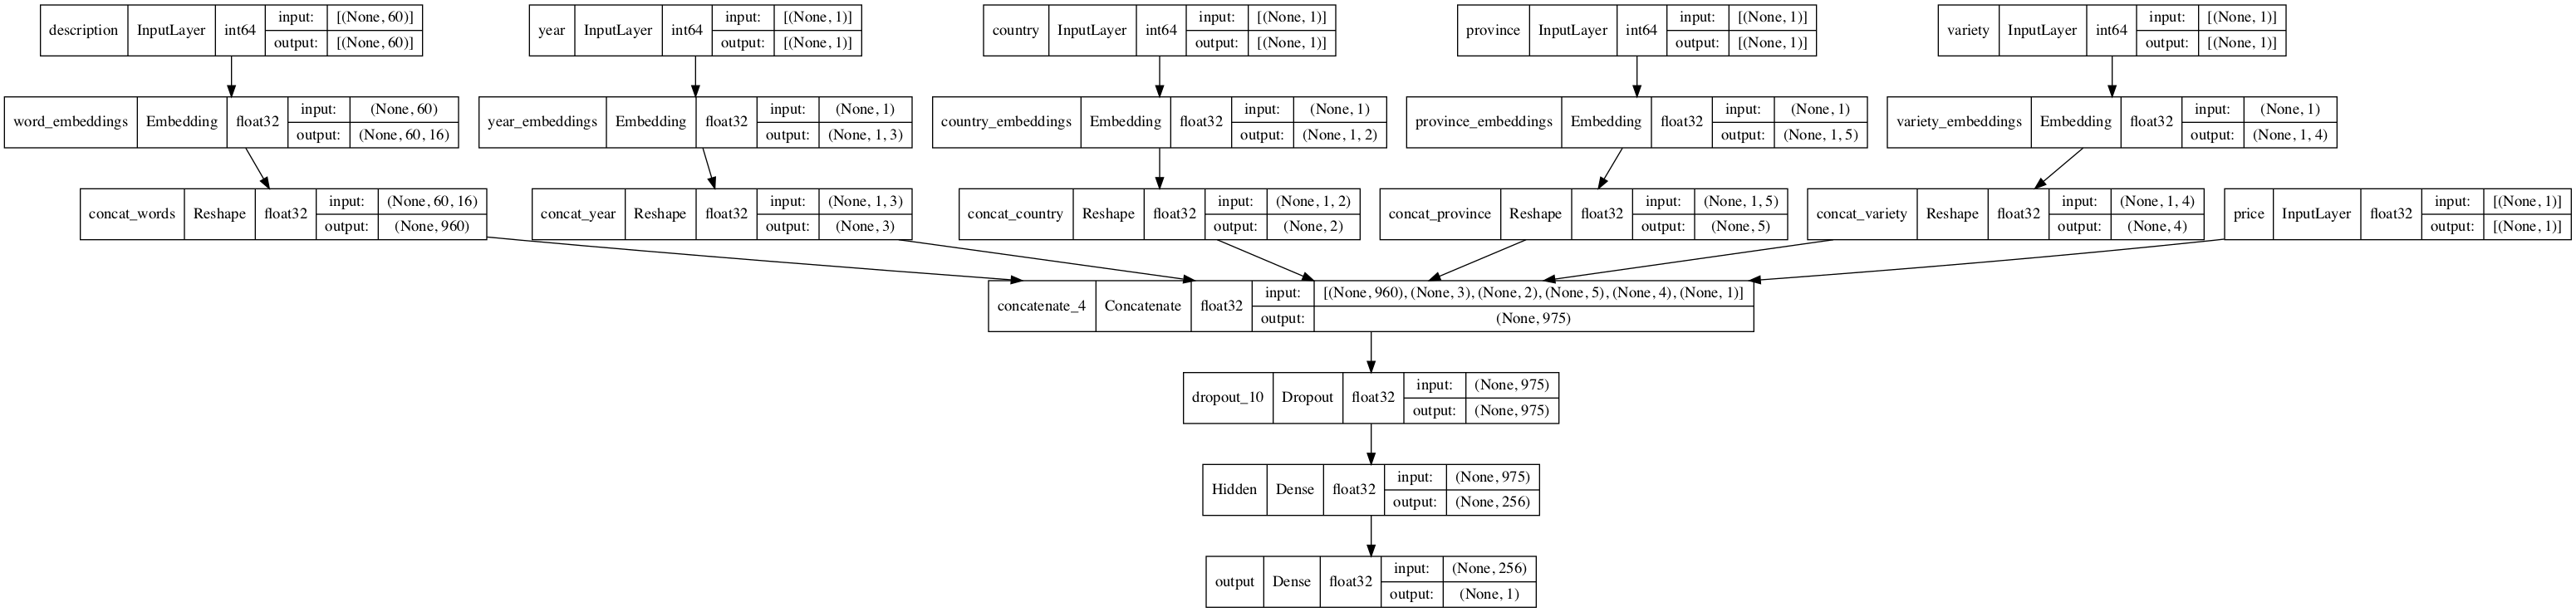

In [113]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [114]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 description (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 country (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 province (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [115]:
training_set = features_df.sample(frac=0.8, random_state=42)
test_set = features_df[~features_df.index.isin(training_set.index)]

In [116]:
assert(len(training_set) + len(test_set) == len(wine_reviews))

In [117]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error')

In [138]:
%%time
history = model.fit(
    {"description": training_set[description_cols].values, 
     "year": training_set['year'].values,
     "country": training_set['country'].values,
     "province": training_set['province'].values,
     "variety": training_set['variety'].values, 
     'price': training_set['price'].values},
    
    {"output": training_set['points'].values},
    validation_data=([test_set[description_cols].values, 
                      test_set['year'].values, 
                      test_set['country'].values, 
                      test_set['province'].values, 
                      test_set['variety'].values, 
                      test_set['price'].values],
                     test_set['points'].values),
    epochs=10,
    batch_size=512,
    verbose=1)

Epoch 1/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7621 - val_loss: 1.2337
Epoch 2/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7751 - val_loss: 1.2021
Epoch 3/10
204/204 [==============================] - 2s 11ms/step - loss: 0.7581 - val_loss: 1.2450
Epoch 4/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7555 - val_loss: 1.2489
Epoch 5/10
204/204 [==============================] - 2s 11ms/step - loss: 0.7402 - val_loss: 1.3149
Epoch 6/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7321 - val_loss: 1.4440
Epoch 7/10
204/204 [==============================] - 2s 11ms/step - loss: 0.7501 - val_loss: 1.2319
Epoch 8/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7457 - val_loss: 1.2171
Epoch 9/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7235 - val_loss: 1.2087
Epoch 10/10
204/204 [==============================] - 2s 10ms/step - loss: 0.7279 - val_lo

In [139]:
history.history

{'loss': [0.7620689868927002,
  0.7751498222351074,
  0.758077085018158,
  0.7555116415023804,
  0.7402492165565491,
  0.7320935726165771,
  0.7501054406166077,
  0.7457071542739868,
  0.7234980463981628,
  0.727931559085846],
 'val_loss': [1.2337310314178467,
  1.2020517587661743,
  1.2450281381607056,
  1.2489192485809326,
  1.3149391412734985,
  1.4440178871154785,
  1.2318662405014038,
  1.2171367406845093,
  1.2086890935897827,
  1.2288484573364258]}

In [140]:
test_set['dnn_prediction'] = model.predict({'description': test_set[description_cols], 
                                            'year': test_set['year'], 
                                            'country': test_set['country'], 
                                            'province': test_set['province'], 
                                            'variety': test_set['variety'], 
                                            'price': test_set['price']})

In [141]:
calc_prediction_quality(test_set, 'dnn_prediction', target_col)

MSE    2.586830
MAE    1.228848
R2     0.719611
dtype: float64

## Using pretrained embeddings

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

## Using transformars

Github repo: https://github.com/UKPLab/sentence-transformers

Supported models list + performances:
* https://www.sbert.net/docs/pretrained_models.html

In [134]:
%%capture
%pip install sentence-transformers

In [194]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [195]:
import pickle
description_vectors_path = 'descriptions_embeddings_desc.pkl'

In [196]:
%%time
description_embeddings = []
for i,description in enumerate(df_pos[text_col].values):
    description_embeddings.append((i,description, model.encode(description)))
    if (i+1) % 1000 == 0:
        print(f'Completed step {i+1} out of {len(df_pos)}')
        pickle.dump(description_embeddings, open(description_vectors_path, 'wb'))

Completed step 1000 out of 30673
Completed step 2000 out of 30673
Completed step 3000 out of 30673
Completed step 4000 out of 30673
Completed step 5000 out of 30673
Completed step 6000 out of 30673
Completed step 7000 out of 30673
Completed step 8000 out of 30673
Completed step 9000 out of 30673
Completed step 10000 out of 30673
Completed step 11000 out of 30673
Completed step 12000 out of 30673
Completed step 13000 out of 30673
Completed step 14000 out of 30673
Completed step 15000 out of 30673
Completed step 16000 out of 30673
Completed step 17000 out of 30673
Completed step 18000 out of 30673
Completed step 19000 out of 30673
Completed step 20000 out of 30673
Completed step 21000 out of 30673
Completed step 22000 out of 30673
Completed step 23000 out of 30673
Completed step 24000 out of 30673
Completed step 25000 out of 30673
Completed step 26000 out of 30673
Completed step 27000 out of 30673
Completed step 28000 out of 30673
Completed step 29000 out of 30673
Completed step 30000 ou

In [197]:
pickle.dump(description_embeddings, open(description_vectors_path, 'wb'))

In [146]:
assert(description_embeddings[1300][1] == df_pos.Desc_concatinated.iloc[1300])

In [198]:
import pickle
descriptions = pickle.load(open('descriptions_embeddings_desc.pkl', 'rb'))

In [199]:
%%time
rows = []
for d in descriptions:
    vector = []
    vector.append(d[0])
    vector.append(d[1])
    for item in d[2]:
        vector.append(item)
    rows.append(vector)   

Wall time: 6.9 s


In [200]:
descriptions_with_sentence_embeddings_df = pd.DataFrame(rows, columns = ['row_id','description'] + [f'embedding_{i}' for i in range(768)])
descriptions_with_sentence_embeddings_df.to_pickle('descriptions_with_sentence_embeddings_df.pkl')

In [156]:
descriptions_with_sentence_embeddings_df

,row_id,description,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,0,date dodge employee productivityyou skills tasks responsibilities business inquires requests resources job training offers position excellent preemployment requirements weekends agent health tasksyou communitiesevery philosophy ethicthe outcome t...,0.035823,0.053661,-0.003921,-0.025520,0.001807,0.041238,0.009403,0.032437,...,0.018125,-0.027542,0.017090,0.022619,0.001115,0.053540,-0.039374,-0.019478,-0.013494,-0.017003
1,1,avis date stay screening constitute skills shop license management responsibilities diagnostics business response safety time drug change job ad brands offers environment bulletins position requirements year variety activities success require vac...,0.027914,0.004649,-0.003909,-0.054476,0.021406,0.023641,0.021505,0.048917,...,0.003256,-0.046415,-0.000359,0.025412,-0.017049,-0.004661,0.001925,-0.006111,0.013735,-0.028230
2,2,opportunity practice shifthours skills license leadership members standards board patient care department processes patients maintaining strategies providers job nursing knowledge communication broadlawns position qualifications experience urodyn...,0.060739,0.055145,-0.032468,-0.052251,-0.001627,0.025879,0.000878,0.020266,...,0.018932,-0.006734,-0.033018,0.038084,-0.027456,-0.006747,-0.000733,-0.001294,0.052152,-0.040087
3,3,stay employee skills license life certifications responsibilities time drug estimate environment qualifications air tools employees customers repairs submit join engine vehicle ase vehicles equipment individuals components chevrolet team products...,-0.019868,0.025763,-0.006227,-0.018974,0.029527,0.047584,-0.021279,0.070887,...,0.002457,-0.032119,0.039204,0.022002,-0.002833,0.030473,-0.032191,-0.019036,0.035487,-0.038349
4,4,avis date stay screening constitute skills shop license management responsibilities diagnostics business response safety time drug change job ad brands offers environment bulletins position requirements variety activities years success require va...,0.029924,0.014260,-0.002191,-0.046672,0.027302,0.033856,0.021100,0.046282,...,0.007270,-0.049723,-0.000136,0.026408,-0.015710,-0.010843,0.006796,-0.006147,0.021968,-0.025977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,30668,customers employment companies license meaningful insurance sales phone join help country percy company calls experience ways health handling people,0.024999,0.066658,-0.015548,-0.069444,0.026987,0.006977,0.039437,0.051516,...,-0.010855,-0.037799,0.027987,0.022482,-0.000434,0.014350,0.022476,-0.003892,0.034050,-0.020033
30669,30669,month client specialist shift newark contract ’ s please opportunity,0.018610,0.079076,-0.024097,-0.025318,-0.023797,0.003349,0.021697,0.028440,...,0.000788,0.028322,0.047784,0.028237,-0.060595,-0.045747,0.014420,-0.017760,-0.025945,-0.039505
30670,30670,month project event calendar draft parttime program management ceo hours areas associations events association manager support maintain provide descriptions,0.032405,0.034072,-0.025040,0.023607,0.022138,0.025813,0.024770,0.025001,...,0.024824,-0.058881,0.030641,0.014223,-0.013415,-0.000985,-0.024924,-0.029173,0.055404,-0.008040
30671,30671,timesfedex communities positions load hire onefedex business ground help medications needs items environment fulltime individuals summaryfedex auto economy part support id packages people,0.002264,0.037130,-0.025601,-0.027582,0.019513,0.057847,0.036693,0.069171,...,-0.002457,-0.030116,0.025012,0.026911,-0.016046,-0.080429,0.001734,-0.010829,-0.004146,-0.000300


In [201]:
descriptions_with_sentence_embeddings_df = descriptions_with_sentence_embeddings_df.set_index('row_id').join(df_pos['JobTitle_tokenized'])

In [173]:
descriptions_with_sentence_embeddings_df.sample(3)

,description,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,JobTitle_tokenized
row_id,,,,,,,,,,,,,,,,,,,,,
1191,practice plansperforms tasks pioneer patients activities years success employer modification designee health traits stateswe state patientsparticipate begin plan diploma deliveredimplements scope career care encounters corresponds company respons...,0.032345,0.035562,-0.014008,-0.049624,-0.039321,0.006992,-0.012206,0.039373,-0.025007,...,0.003110,-0.034172,-0.007459,-0.013831,0.046944,0.036691,0.007598,0.031172,-0.047833,9
3443,adult date feel search hour please malpractice insurance travel board call vacancy hours time week consideration schedule orleans shifts director position qualifications location compensation exceptional deposits questions la end details,0.040429,0.039945,-0.023618,-0.012072,-0.025879,0.007292,-0.007069,0.043331,-0.008007,...,-0.015097,-0.016962,0.028492,-0.017967,-0.031858,-0.012832,-0.004747,0.017798,-0.002533,13
29219,practices field profession communities towards advocacy promote promising energy forefront time chiefs member efforts services individuals association passion police,0.031791,0.048847,0.004345,-0.008479,-0.011075,0.016110,0.031348,-0.006406,-0.047035,...,-0.030285,-0.009848,0.006334,0.017565,-0.041811,-0.020480,0.017025,0.025316,-0.024981,1384


In [175]:
s = descriptions_with_sentence_embeddings_df[['description','JobTitle_tokenized']].sample()
s.values

array([['customers client owings booklets hire look md mills create position comprehensive team production support data design opportunity investment',
        723]], dtype=object)

In [176]:
descriptions_with_sentence_embeddings_df.query('description == @s.description.iloc[0]')['JobTitle_tokenized']

row_id
27730    723
Name: JobTitle_tokenized, dtype: int64

### Modedling with transformers sequence embeddings

In [351]:
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout, Reshape, Activation

In [352]:
text_col, target_col = 'Desc_concatinated', 'JobTitle_tokenized'

from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()

label_as_binary.fit(df_pos[target_col])

training = descriptions_with_sentence_embeddings_df.sample(frac=0.8, random_state=41)
test = descriptions_with_sentence_embeddings_df[~descriptions_with_sentence_embeddings_df.index.isin(training_set.index)]

train__y_labels = label_as_binary.transform(training[target_col])
test__y_labels = label_as_binary.transform(test[target_col])

In [353]:
model = tf.keras.Sequential()
model.add(Dense(4096, input_dim=768))
model.add(Activation('elu'))
# model.add(Dense(2048, input_dim=2048))
# model.add(Activation('relu'))
model.add(Dense(df_pos.JobTitle.nunique()))
model.add(Activation('softmax'))
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy'])

In [354]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 4096)              3149824   
                                                                 
 activation_16 (Activation)  (None, 4096)              0         
                                                                 
 dense_19 (Dense)            (None, 1953)              8001441   
                                                                 
 activation_17 (Activation)  (None, 1953)              0         
                                                                 
Total params: 11,151,265
Trainable params: 11,151,265
Non-trainable params: 0
_________________________________________________________________


In [236]:
f_vector = [f'embedding_{i}' for i in range(768)]
history = model.fit(training[f_vector], 
          train__y_labels, 
          validation_data=(test[f_vector], test__y_labels), 
          epochs=7,
          batch_size=1024,
          verbose=1)

Epoch 1/7
24/24 [==============================] - 65s 2s/step - loss: 5.4789 - accuracy: 0.1682 - val_loss: 4.2368 - val_accuracy: 0.2730
Epoch 2/7
24/24 [==============================] - 48s 2s/step - loss: 3.7024 - accuracy: 0.3435 - val_loss: 3.3613 - val_accuracy: 0.4060
Epoch 3/7
24/24 [==============================] - 46s 2s/step - loss: 2.9543 - accuracy: 0.4436 - val_loss: 2.9111 - val_accuracy: 0.4745
Epoch 4/7
24/24 [==============================] - 48s 2s/step - loss: 2.4572 - accuracy: 0.5062 - val_loss: 2.6763 - val_accuracy: 0.5180
Epoch 5/7
24/24 [==============================] - 53s 2s/step - loss: 2.1160 - accuracy: 0.5458 - val_loss: 2.5480 - val_accuracy: 0.5460
Epoch 6/7
24/24 [==============================] - 50s 2s/step - loss: 1.8710 - accuracy: 0.5754 - val_loss: 2.4753 - val_accuracy: 0.5601
Epoch 7/7
24/24 [==============================] - 55s 2s/step - loss: 1.6606 - accuracy: 0.6058 - val_loss: 2.4745 - val_accuracy: 0.5803


### Simple NN Prediction & Evaluation

In [237]:
import matplotlib.pyplot as plt

<AxesSubplot:>

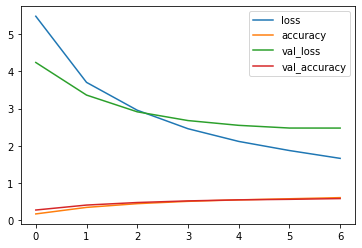

In [238]:
pd.DataFrame(history.history).plot()

In [239]:
test['token_with_best_prediction'] = model.predict(test[f_vector]).argmax(axis=1)

In [240]:
test['prob_token_with_best_prediction'] = model.predict(test[f_vector]).max(axis=1)

In [241]:
test.sample()

,description,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,JobTitle_tokenized,token_with_best_prediction,prob_token_with_best_prediction
row_id,,,,,,,,,,,,,,,,,,,,,
21416,crew back needed employee operation riding tasks assisting addition responsibilities reuse safety minor assistants include job climb reach qualifications collecting directing able pull might runs backing deep procedures materials repairs worker s...,0.012539,0.040313,0.001041,-0.010056,0.016563,0.017076,-0.00874,0.029859,-0.049438,...,0.032346,-0.011281,0.00157,-0.019672,-0.028543,0.02939,-0.013297,625,625,0.506288


In [244]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print(precision_score(test['JobTitle_tokenized'],test['token_with_best_prediction'], average="macro"))
print(recall_score(test['JobTitle_tokenized'],test['token_with_best_prediction'], average="macro"))    
print(accuracy_score(test['JobTitle_tokenized'],test['token_with_best_prediction']))    

0.14370096162910206
0.1601902503366367
0.5802770986145069


C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\envs\ML Technion\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



### Making a loop to see the best metrics

In [355]:
f_vector = [f'embedding_{i}' for i in range(768)]
transformer_results2 = [0]*100
for i in range(100):
    history_loop = model.fit(training[f_vector], 
                              train__y_labels, 
                              validation_data=(test[f_vector], test__y_labels), 
                              epochs=1,
                              batch_size=1024,
                              verbose=1)
    
    prob = model.predict(test[f_vector])
    test['token_with_best_prediction'] = prob.argmax(axis=1)
#     test['prob_token_with_best_prediction'] = prob.max(axis=1)
    
    transformer_results2[i] = [i,
                            precision_score(test['JobTitle_tokenized'],test['token_with_best_prediction'], average="weighted", zero_division=0),
                            recall_score(test['JobTitle_tokenized'],test['token_with_best_prediction'], average="weighted", zero_division=0), 
                            accuracy_score(test['JobTitle_tokenized'],test['token_with_best_prediction'])]

24/24 [==============================] - 50s 2s/step - loss: 0.2009 - accuracy: 0.9409 - val_loss: 2.9212 - val_accuracy: 0.6877


In [356]:
transformer_results2

[[0, 0.1688545060703858, 0.29013854930725347, 0.29013854930725347],
 [1, 0.3042896224874216, 0.4299918500407498, 0.4299918500407498],
 [2, 0.36702795223396867, 0.480358598207009, 0.480358598207009],
 [3, 0.43342432265426306, 0.519641401792991, 0.519641401792991],
 [4, 0.4785023567020251, 0.5501222493887531, 0.5501222493887531],
 [5, 0.5085178753582213, 0.5711491442542788, 0.5711491442542788],
 [6, 0.5268077409194141, 0.5853300733496333, 0.5853300733496333],
 [7, 0.5468644776813835, 0.6016299918500407, 0.6016299918500407],
 [8, 0.5731223056026608, 0.6114099429502853, 0.6114099429502853],
 [9, 0.5813119854266914, 0.6187449062754686, 0.6187449062754686],
 [10, 0.5975799234288662, 0.6278728606356968, 0.6278728606356968],
 [11, 0.5981591104907148, 0.632599837000815, 0.632599837000815],
 [12, 0.615149600660839, 0.6427057864710677, 0.6427057864710677],
 [13, 0.6190977214469068, 0.6488997555012225, 0.6488997555012225],
 [14, 0.62724378904135, 0.6537897310513447, 0.6537897310513447],
 [15, 0.62

[0.673, 0.687]

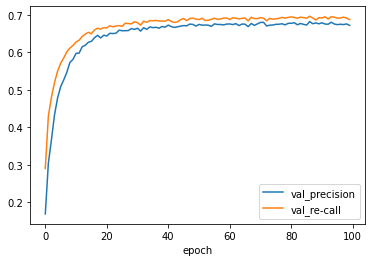

In [358]:
pd.DataFrame(transformer_results2, columns=['epoch','val_precision','val_re-call','val_accuracy']).set_index('epoch')[['val_precision','val_re-call']].plot()
[0.673, 0.687]